In [1]:
!pip install -q formulaic

import numpy as np
import pandas as pd
import datetime as dt
from formulaic import Formula
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Метрики
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# Модели
from sklearn.linear_model import LogisticRegression

In [2]:
def data_preprocess(data):
    data['date_time'] = pd.to_datetime(data['date_time'])
    # Удаляем колонки, которые по условию не нужны для 1го ДЗ
    data = data.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1)
    return data

def log_column(column: pd.Series):
    log_column = column.copy()
    log_column[column != 0] = np.log(column[column != 0])
    log_column[column == 0] = log_column.min() - 1
    return log_column

In [3]:
data = pd.read_csv('../data/data.csv')
data = data_preprocess(data)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


### EDA

* Общее число наблюдений: 15821472 

* 1. Число наблюдений по дням; 
  2. Все значения impressions = 1


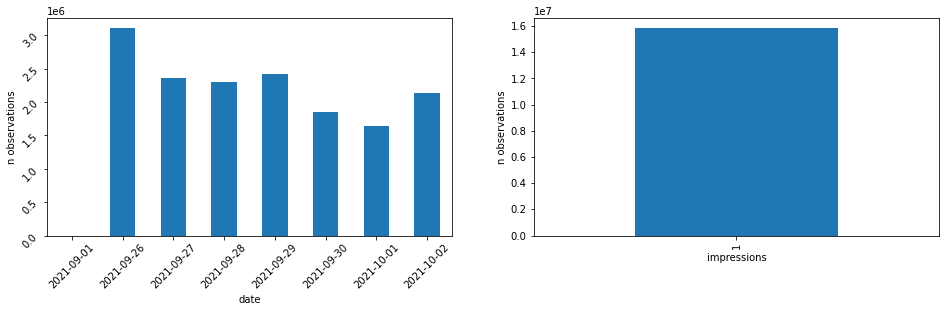

* 1. Гистограмма date_time.hour; 
  2. Cреднее число кликов в зависимости от date_time.hour


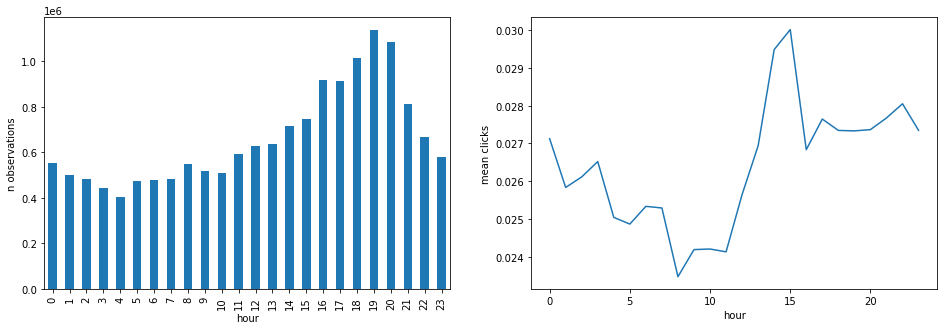

* 1. Гистограмма date_time.weekday; 
  2. Cреднее число кликов в зависимости от date_time.weekday


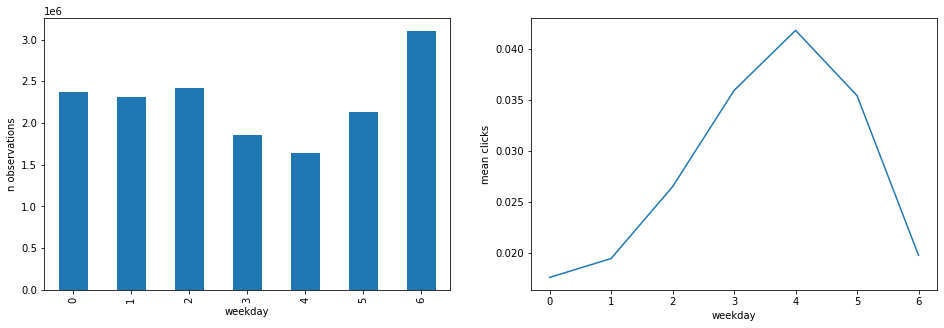

* 1. Гистограмма zone_id; 
  2. Гистограмма banner_id


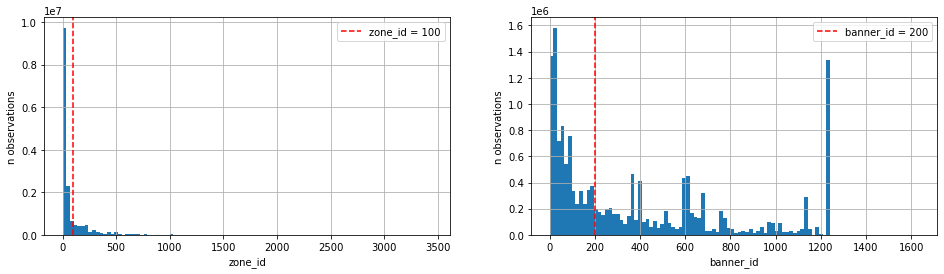

* 1. Гистограмма всех значений campaign_clicks; 
* 2. Гистограмма первых 10 значений campaign_clicks; 
  3. Cреднее число кликов в зависимости от логарифма campaign_clicks (не включая campaign_clicks=0)


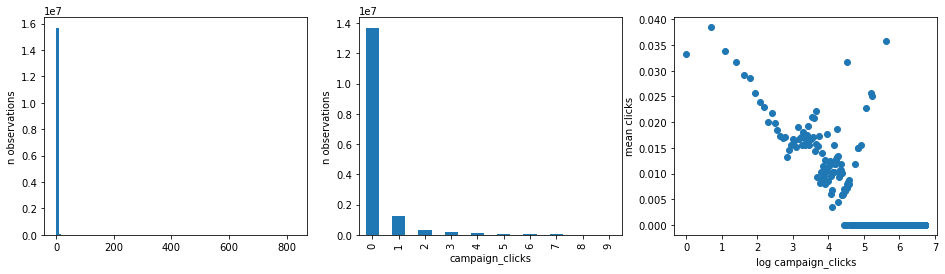

* 1. Гистограмма country_id; 
  2. Cреднее число кликов в зависимости от country_id


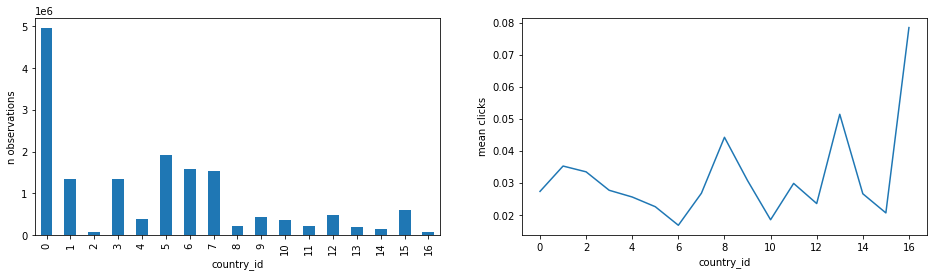

* 1. Гистограмма os_id; 
  2. Cреднее число кликов в зависимости от os_id


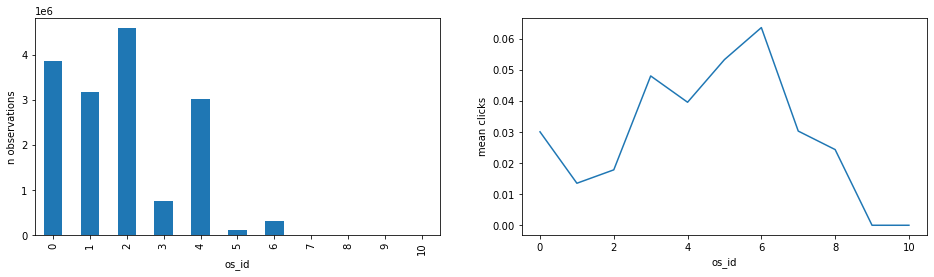

CPU times: user 16.1 s, sys: 497 ms, total: 16.6 s
Wall time: 16.6 s


In [4]:
%%time
# Общее число наблюдений
print(f'* Общее число наблюдений: {len(data)} \n')

### date_time

# Число наблюдений по дням
print('* 1. Число наблюдений по дням; \n'
      '  2. Все значения impressions = 1')

fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)

data.groupby(data['date_time'].dt.date.map(str)).size().plot.bar(ax=axes[0])
axes[0].set_ylabel('n observations')
axes[0].set_xlabel('date')
axes[0].tick_params(labelrotation=45)

data.groupby('impressions').size().plot.bar(ax=axes[1])
axes[1].set_ylabel('n observations')
axes[1].set_xlabel('impressions')

plt.show()

# date_time.hour
print('* 1. Гистограмма date_time.hour; \n'
      '  2. Cреднее число кликов в зависимости от date_time.hour')
fig, axes = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)

data.groupby(data['date_time'].dt.hour).size().plot.bar(ax=axes[0])
axes[0].set_xlabel('hour')
axes[0].set_ylabel('n observations')

data.groupby(data['date_time'].dt.hour).agg({'clicks': 'mean'}).plot(ax=axes[1], legend=False)
axes[1].set_xlabel('hour')
axes[1].set_ylabel('mean clicks')

plt.show()

# date_time.weekday
print('* 1. Гистограмма date_time.weekday; \n'
      '  2. Cреднее число кликов в зависимости от date_time.weekday')
fig, axes = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)

data.groupby(data['date_time'].dt.weekday).size().plot.bar(ax=axes[0])
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('n observations')

data.groupby(data['date_time'].dt.weekday).agg({'clicks': 'mean'}).plot(ax=axes[1], legend=False)
axes[1].set_xlabel('weekday')
axes[1].set_ylabel('mean clicks')

plt.show()

### zone_id и  banner_id
print('* 1. Гистограмма zone_id; \n'
      '  2. Гистограмма banner_id')

fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)

data['zone_id'].hist(bins=100, ax=axes[0])
axes[0].axvline(x=100, ymin=0, ymax=1, c='r', linestyle='--', label='zone_id = 100')
axes[0].set_ylabel('n observations')
axes[0].set_xlabel('zone_id')
axes[0].legend()

data['banner_id'].hist(bins=100, ax=axes[1])
axes[1].axvline(x=200, ymin=0, ymax=1, c='r', linestyle='--', label='banner_id = 200')
axes[1].set_ylabel('n observations')
axes[1].set_xlabel('banner_id')
axes[1].legend()

plt.show()

### campaign_clicks

print("* 1. Гистограмма всех значений campaign_clicks; \n"
      "* 2. Гистограмма первых 10 значений campaign_clicks; \n"
      "  3. Cреднее число кликов в зависимости от логарифма campaign_clicks (не включая campaign_clicks=0)")

fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)

data['campaign_clicks'].plot.hist(bins=100, ax=axes[0])
axes[0].set_ylabel('n observations')

data.groupby('campaign_clicks').size()[:10].plot.bar(ax=axes[1])
axes[1].set_ylabel('n observations')

campaign_clicks_clicks = data.groupby('campaign_clicks').agg({'clicks': 'mean'}).reset_index()
campaign_clicks_clicks = campaign_clicks_clicks[campaign_clicks_clicks['campaign_clicks'] != 0]
axes[2].scatter(log_column(campaign_clicks_clicks['campaign_clicks']), campaign_clicks_clicks['clicks'])
axes[2].set_xlabel('log campaign_clicks')
axes[2].set_ylabel('mean clicks')

plt.show()

### country_id
print('* 1. Гистограмма country_id; \n'
      '  2. Cреднее число кликов в зависимости от country_id')


fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)

data.groupby('country_id').size().plot.bar(ax=axes[0])
axes[0].set_ylabel('n observations')

data.groupby('country_id').agg({'clicks': 'mean'}).plot(ax=axes[1], legend=False)
axes[1].set_ylabel('mean clicks')

plt.show()

### os_id
print('* 1. Гистограмма os_id; \n'
      '  2. Cреднее число кликов в зависимости от os_id')

fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=2)

data.groupby('os_id').size().plot.bar(ax=axes[0])
axes[0].set_ylabel('n observations')

data.groupby('os_id').agg({'clicks': 'mean'}).plot(ax=axes[1], legend=False)
axes[1].set_ylabel('mean clicks')

plt.show()

### Выводы по EDA

1. Вероятность клика зависит от часа и дня недели => добавим в модель дамми для часа, дня недели и их интеракции


2. Зона и баннер (основные предикторы) сосредотачивают большинство наблюдений в начальном диапазоне: большинство zone_id от 0 до 100; banner_id - от 0 до 200. Таким образом, для этих наблюдений можно включить в модель их интеракции. С одной стороны это покроет бОльшую часть данных, с другой - не сделает модель слишком большой для вычислений:
    
        100 * 200 = 20.000 параметров vs 5.624.052 = 3444 * 1633 (интеракции всех zone_id и banner_id)
Таким образом, включаем в модель дамми для всех zone_id и banner_id, а также отдельно дамми для интеракций zone_id от 0 до 100 c banner_id от 0 до 200.


3. Сampaign_clicks преимущественно равны 0. Остальные немногочсиленные значения имеют лог-линейную зависимость со средним числом кликов. Таким образом, добавим в модель дамми campaign_clicks = 0, и log(campaign_clicks) для остальных значений


4. Также сделаем дамми для country_id и os_id

### Feature engineering

In [5]:
%%time
### Делаем копию исходного датасета для добавления новых фичей
_data = data.copy()

### Фичи, свзязанные с date_time

_data['hour'] = _data['date_time'].dt.hour
_data['weekday'] = _data['date_time'].dt.weekday
# Удаляем колонку date_time
_data = _data.drop('date_time', axis=1)

### Фичи, свзязанные с zone_id

# Считаем кол-во наблюдений для каждой зоны и оставляем и выбираем топ n
zone_id_vc = data['zone_id'].value_counts()
zone_id_top = zone_id_vc[:100].index
# Делим колонку zone_id на две по кол-ву наблюдений
_data['zone_id_top'] = _data['zone_id'] * _data['zone_id'].isin(zone_id_top)

### Фичи, свзязанные с banner_id

# Считаем кол-во наблюдений для каждой зоны и оставляем и выбираем топ n
banner_id_vc = data['banner_id'].value_counts()
banner_id_top = banner_id_vc[:200].index
# Делим колонку banner_id на две по кол-ву наблюдений
_data['banner_id_top'] = _data['banner_id'] * _data['banner_id'].isin(banner_id_top)

### Фичи, свзязанные с campaign_clicks

# Логарифмируем колонку, так как нелинейная зависимость
_data['log_campaign_clicks'] = log_column(_data['campaign_clicks'])
# Отдельно выделим классы когда число кликов равно 0
_data['campaign_clicks_eq_0'] = (_data['campaign_clicks'] == 0).astype(int)
# Удаляем колонку campaign_clicks
_data = _data.drop('campaign_clicks', axis=1)

CPU times: user 2.96 s, sys: 2.04 s, total: 5 s
Wall time: 4.83 s


### Model

In [6]:
%%time
formula = "clicks ~ C(zone_id_top):C(banner_id_top)" \
                " + C(zone_id)" \
                " + C(banner_id)" \
                " + campaign_clicks_eq_0" \
                " + log_campaign_clicks" \
                " + C(hour)" \
                " + C(weekday)" \
                " + C(hour):C(weekday)" \
                " + C(os_id)" \
                " + C(country_id)"

y, X = Formula(formula).get_model_matrix(_data, output='sparse')
print(f'Кол-во фичей: {X.shape[1]}')

Кол-во фичей: 25270
CPU times: user 3min 2s, sys: 1.7 s, total: 3min 3s
Wall time: 3min 4s


In [7]:
%%time
# Делим выборку на обучающую и тестовую по последнему дню
X_train = X[data['date_time'].dt.date != dt.date(2021, 10, 2)]
y_train = y[data['date_time'].dt.date != dt.date(2021, 10, 2)].toarray().ravel()

X_test =  X[data['date_time'].dt.date == dt.date(2021, 10, 2)]
y_test =  y[data['date_time'].dt.date == dt.date(2021, 10, 2)].toarray().ravel()

CPU times: user 16.7 s, sys: 916 ms, total: 17.6 s
Wall time: 17.8 s


In [8]:
# Среднее предсказание
p_mean = y_train.mean()
log_loss_baseline = log_loss(y_test, [p_mean] * len(y_test))
auc_baseline = roc_auc_score(y_test, [p_mean] * len(y_test))

print(f'log_loss baseline: {log_loss_baseline}')
print(f'auc baseline     : {auc_baseline}')

log_loss baseline: 0.15486198009919555
auc baseline     : 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

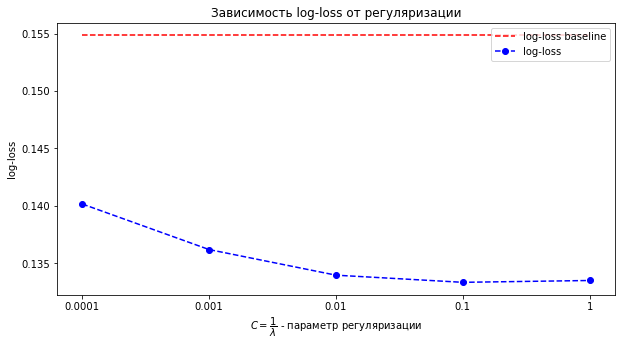

CPU times: user 37min 14s, sys: 6min 34s, total: 43min 48s
Wall time: 9min 53s


In [9]:
%%time
# Различные параметры регуляризации
C = [.0001, .001, .01, .1, 1]
log_losses = [None] * 5
aucs = [None] * 5

# Строим логистическую регрессия с различными параметрами регуляризации
for i, c in enumerate(tqdm(C)):
    clf = LogisticRegression(solver='liblinear', C=c)
    clf.fit(X_train, y_train)

    pred=clf.predict_proba(X_test)
    
    log_losses[i] = log_loss(y_test, pred)
    aucs[i] = roc_auc_score(y_test, pred[:, 1])

# График зависимости log-loss от регуляризации
plt.figure(figsize=(10, 5))
plt.hlines(y=log_loss_baseline, xmin=0, xmax=len(C) - 1, linestyle='--', color='r', label='log-loss baseline')
plt.plot(log_losses, marker='o', linestyle='--', color='b', label='log-loss') 
plt.xticks(ticks=range(5), labels=C)
plt.title('Зависимость log-loss от регуляризации')
plt.xlabel(r'$C = \dfrac{1}{\lambda}$ - параметр регуляризации')
plt.ylabel('log-loss')
plt.legend()
plt.show()

In [13]:
best_idx = 3

print(f'C =        {C[best_idx]}')
print(f'log_loss = {log_losses[best_idx]}')
print(f'auc =      {aucs[best_idx]}')

C =        0.1
log_loss = 0.1333386672069001
auc =      0.7883412503326696


### Results

**C** = 0.1 - параметр регуляризации

**log_loss** = 0.13334  < 1.5 (baseline)

**auc** = 0.788 > 0.5 (baseline)